# Tutorial 7b: Dancing

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t7b_dancing.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/t7b_dancing.ipynb).*

This tutorial was inspired by [Geoff Cumming](http://www.latrobe.edu.au/psychology/staff/profile?uname=GDCumming).

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

In this exercise, we will investigate how **replicable** certain statistical conclusions, both the frequentist and Bayesian contexts, are.  What I mean by replicability is best understood be working through the tutorial.

For this tutorial we will use the zebrafish embryo sleep data we have been using before.  We will investigate one of the metrics we considered in [Tutorial 2b](../tutotials/t2b_defining_and_estimating_parameters.html).  We will study the mean rest bout length on the third night, comparing wild type to the homozygous mutant.  We are primarily interested in the *difference* in the mean bout lengths between the two genotypes. You could work through Tutorial 2b again to process the bout lengths and get the data, but I provide them for you [here](../data/mean_rest_bouts.csv).

As a reminder, two of the mutant fish had no detectable rest bouts on the one-minute sampling interval.  They obviously did have rest bouts, but they were smaller than one minute.  We therefore have a decision: we can either choose the mean rest bout length to be zero for these fish, or we can jettison them from our samples because we know we could not properly sample them.  For the purposes of this demonstration, we will neglect these points. (The purpose of this tutorial is to demonstrate reproducibility of statistics, not analyze this specific data set.)

Let's remind ourselves of what the data look like.

In [2]:
# Load data
df = pd.read_csv('../data/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and drop NAs
df = df[df['genotype'].isin(['wt', 'mut'])].dropna()

Let's look at these data with a bee swarm plot.

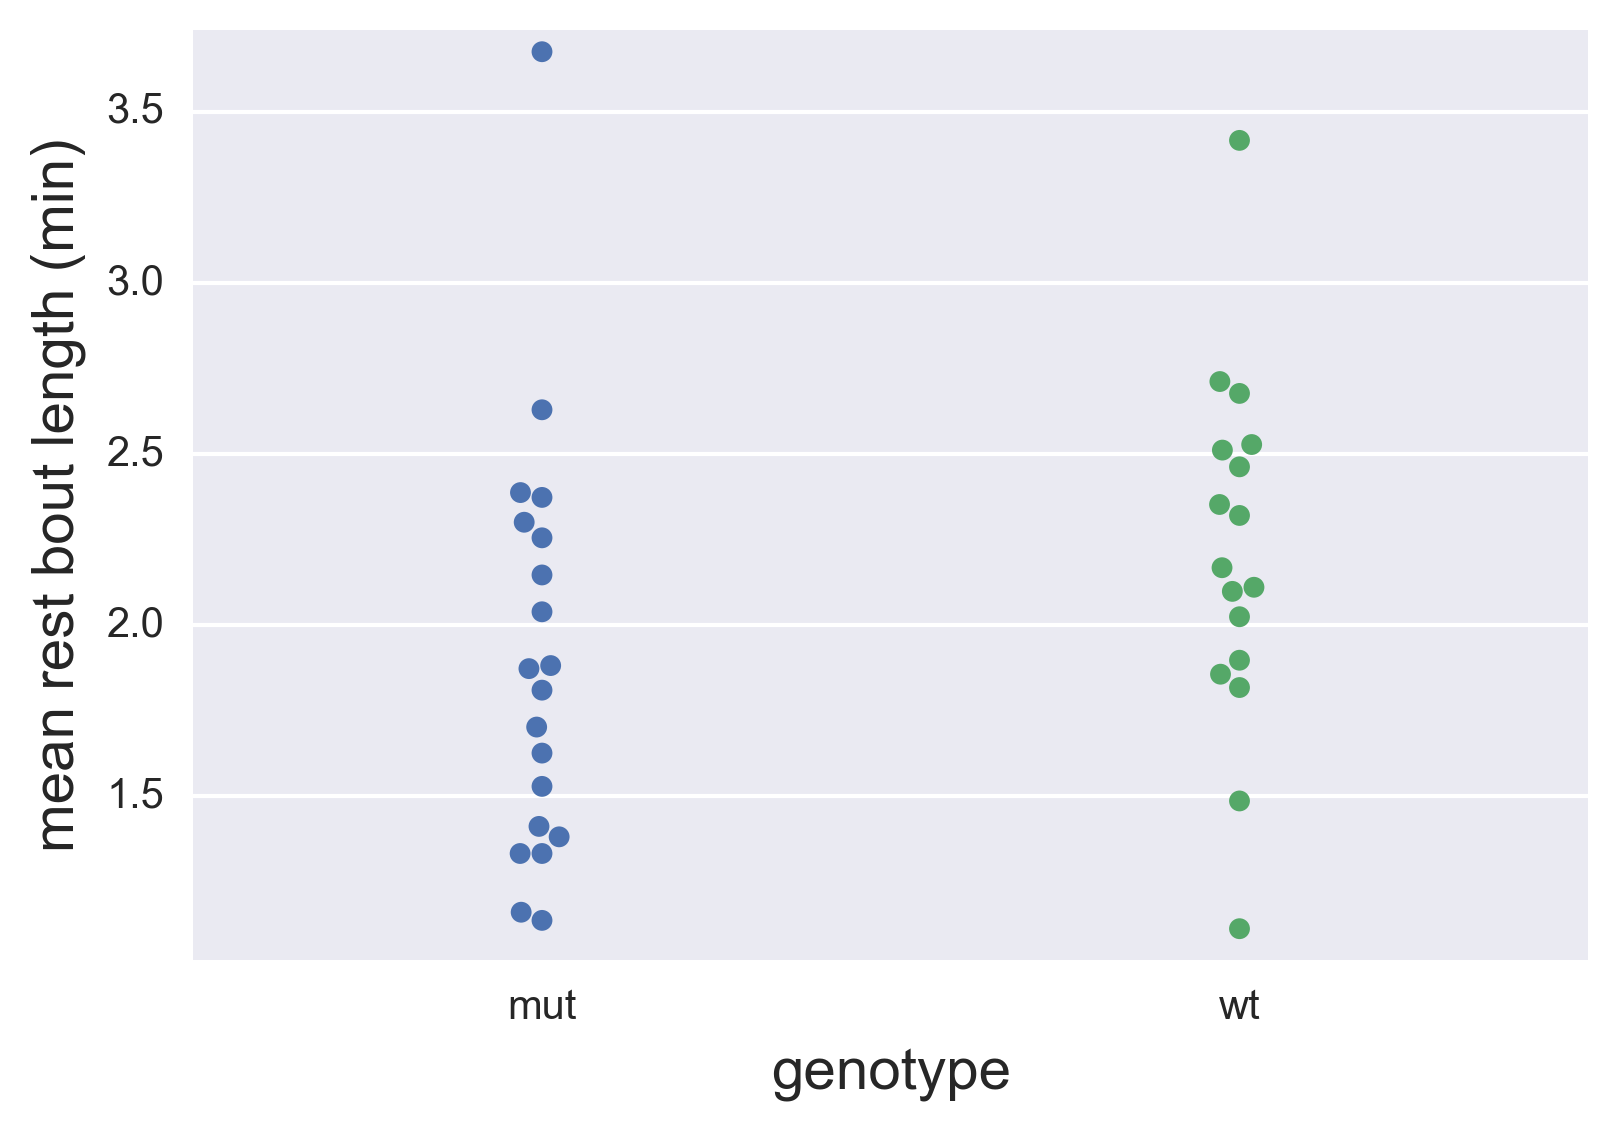

In [3]:
# Make bee swarm plot
sns.swarmplot(x='genotype', y='mean_rest_bout_length', data=df)

# Label axes 
plt.ylabel('mean rest bout length (min)')
plt.margins(y=0.02)

### Estimates of the difference of means and Cohen's d

First, we will compute nonparametric estimates from the data. We will estimate the difference in the mean bout length and Cohen's d. For speed, we save the two data sets as NumPy arrays.

In [4]:
wt = df.loc[df.genotype=='wt', 'mean_rest_bout_length'].values
mut = df.loc[df.genotype=='mut', 'mean_rest_bout_length'].values

Next, we'll write some functions to conveniently generate bootstrap replicates and do our hypothesis tests. These borrow heavily from the [previous tutorial](t7a_hacker_stats.html).

In [5]:
@numba.jit(nopython=True)
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = x.mean() - y.mean()
    pooled_variance = (len(x) * np.var(x) + len(y) * np.var(y)) \
                            / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)


@numba.jit(nopython=True)
def t_stat(x, y):
    """Welch's t-statistic."""
    return (np.mean(x) - np.mean(y)) / \
        np.sqrt(np.var(x) / (len(x) - 1) + np.var(y) / (len(y) - 1))

    
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]
    
    
@numba.jit(nopython=True)
def draw_bs_sample(data):
    return np.random.choice(data, size=len(data))


@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=10000):
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_diff_mean(x, y, size=10000):
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_cohen_d(x, y, size=10000, return_abs=False):
    out = np.empty(size)
    for i in range(size):
        out[i] = cohen_d(draw_bs_sample(x), draw_bs_sample(y), return_abs)
    return out

@numba.jit(nopython=True)
def draw_bs_reps_t(x, y, size=10000):
    """
    Bootstrap replicates using the Welch's t-statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = t_stat(draw_bs_sample(x), draw_bs_sample(y))
    return out

Now we can compute the replicates. First, let just look at the means and their respective confidence intervals.

In [6]:
wt_reps = draw_bs_reps_mean(wt)
mut_reps = draw_bs_reps_mean(mut)

And from these, compute the 95% confidence interval.

In [7]:
wt_mean_conf_int = np.percentile(wt_reps, [2.5, 97.5])
mut_mean_conf_int = np.percentile(mut_reps, [2.5, 97.5])

print('WT:  [{1:.2f}, {0:.2f}, {2:.2f}] minutes'.format(
                np.mean(wt), *tuple(wt_mean_conf_int)))
print('MUT: [{1:.2f}, {0:.2f}, {2:.2f}] minutes'.format(
                np.mean(mut), *tuple(mut_mean_conf_int)))

WT:  [1.98, 2.21, 2.45] minutes
MUT: [1.65, 1.90, 2.18] minutes


There is some overlap in the confidence interval, though wild type tend to have longer rest bouts. Just looking at these numbers, we may not be all that certain that there is a discernible difference between wild type and mutant. (Remember, though, that we left out the two fish that did not have rest bouts at all. It could be that the key difference between the two genotypes is that *some* mutants do not sleep at all, while those that do have similar rest bout lengths as wild type.)

Now, let's look at the difference in the mean  rest bout length.

In [8]:
reps = draw_bs_reps_diff_mean(wt, mut)
diff_mean_conf_int = np.percentile(reps, [2.5, 97.5])

print('WT - MUT:  [{1:.2f}, {0:.2f}, {2:.2f}] minutes'.format(
                np.mean(wt) - np.mean(mut), *tuple(diff_mean_conf_int)))

WT - MUT:  [-0.06, 0.31, 0.65] minutes


As we might expect, on the tail end of the confidence interval for the difference of means, we see that the mutant might actually have longer rest bouts that wild type.

Finally, lets compute the Cohen's d to check the effect size.

In [9]:
reps = draw_bs_reps_cohen_d(wt, mut)
cohen_d_conf_int = np.percentile(reps, [2.5, 97.5])

print('WT - MUT Cohen''s d:  [{1:.2f}, {0:.2f}, {2:.2f}] minutes'.format(
                cohen_d(wt, mut), *tuple(cohen_d_conf_int)))

WT - MUT Cohens d:  [-0.08, 0.56, 1.46] minutes


So, the effect size is 0.56, meaning that the mutant tends to have rest bouts 0.5 standard deviations as large as wild type fix. Jacob Cohen would call this a "medium" sized effect. 

### NHST

We will now perform an NHST on these two data sets. We formulate the hypothesis as such: $H_0$: Wild type and mutant fish have the same mean rest about length. We will choose the Cohen's d as our test statistic. We can then perform a bootstrap hypothesis test.

In [10]:
@numba.jit(nopython=True)
def cohen_nhst(wt, mut, size=100000):
    """
    Perform hypothesis test assuming equal means, using
    Cohen-d as test statistic.
    """
    # Shift data sets so that they have the same mean.
    wt_shifted = wt - np.mean(wt) + np.mean(np.concatenate((wt, mut)))
    mut_shifted = mut - np.mean(mut) + np.mean(np.concatenate((wt, mut)))

    # Draw replicates of Cohen's d
    reps = draw_bs_reps_cohen_d(wt_shifted, mut_shifted, size=size)

    # Compute p-value
    return np.sum(reps >= cohen_d(wt, mut)) / len(reps)

print("Cohen's d p-value:", cohen_nhst(wt, mut))

Cohen's d p-value: 0.06633


We get a p-value of about 0.07, which, if we use the typical bright line p-value for statistical significance, we would say that this difference is not statistically significant. We could also test what would happen if we used a different test statistic, like the difference of means.

In [11]:
# Shift data sets so that they have the same mean.
wt_shifted = wt - np.mean(wt) + np.mean(np.concatenate((wt, mut)))
mut_shifted = mut - np.mean(mut) + np.mean(np.concatenate((wt, mut)))

# Draw replicates of Cohen's d
reps = draw_bs_reps_diff_mean(wt_shifted, mut_shifted, size=100000)

# Compute p-value
p_val = np.sum(reps >= np.mean(wt) - np.mean(mut)) / len(reps)

print('Difference of means p-value:', p_val)

Difference of means p-value: 0.04039


Here, we get a p-value of about 0.04. We would say that the result is statistically significant if we used a bright line value of 0.05.

Finally, let's try the canonical test for this circumstance, the Welch's t-test. As a reminder, the test statistic for the Welch's t-test is

\begin{align}
T = \frac{\bar{x}_w - \bar{x}_m}{\sqrt{r_w^2/n_w + r_m^2/n_m}},
\end{align}

where $r_w^2$ and $r_m^2$ are plug-in estimates for the variances.  Importantly, when performing a Welch's t-test, Gaussianity of the two samples is assumed. So, the hypothesis is, $H_0'$: The two samples are both Gaussian distributed with equal means. 

This is implemented as `st.ttest_ind()` using the kwarg `equal_var=False`. We divide by two to get the one-tailed test.

In [12]:
print("Welch's p-value:", st.ttest_ind(wt, mut, equal_var=False)[1]/2)

Welch's p-value: 0.0525420049088


Here, we are just above the bright line value of 0.05. We can perform a similar hypothesis test without the Gaussian assumption using the same test statistic as in the Welch's test.

In [13]:
# Draw replicates of t statistic
reps = draw_bs_reps_t(wt_shifted, mut_shifted, size=100000)

# Compute p-value
p_val = np.sum(reps >= t_stat(wt, mut)) / len(reps)

print("Welch's t-test without Gaussian assumption p-value:", p_val)

Welch's t-test without Gaussian assumption p-value: 0.06376


Finally, we will perform a permutation test. Remember that the hypothesis of the permutation test is $H_0$: The sleep bout lengths of mutant and wild type fish are identically distributed. Our test statistic is the difference of means, since it gives exactly the same result as the studentized test statistic.

In [14]:
# Draw permutation replicates
reps = draw_perm_reps_diff_mean(wt, mut, size=100000)

# Compute p-value
p_val = np.sum(reps >= np.mean(wt) - np.mean(mut)) / len(reps)

print("Permutation test p-value:", p_val)

Permutation test p-value: 0.05574


So, all of our tests give p-values that are close to each other, ranging from about 0.04 to 0.07. If we choose bright line p-values to deem something as significant or not, some similar hypothesis/test statistic pairs can give different results. So, beware!

### A Bayesian analysis

For a Bayesian model selection problem, we could do the same modeling, assume that the two distributions have the same mean, but not choose a model for how the data are distributed. This is a nonparametric Bayesian calculation, which is mathematically more challenging than the frequentist estimates and NHST we just did.

Instead, we will do a parameteric Bayesian model selection, comparable to the Welch's t-test analysis.

First, we do some analytical work. We have two data sets, $D_w$ and $D_m$. We define hypothesis $H_1$: these data sets were drawn from independent Gaussian distributions with differing means and differing variances. The competing hypothesis is $H_0'$: the data sets were drawn from independent Gaussian distributions with the same mean, $\mu$, but different variances. Since we are computing confidence intervals of the difference or means, we will not consider $H_0'$ in the Bayesian context, except for model selection.

So, using hypothesis $H_1$, the likelihood is

\begin{align}
&P(D_w,D_m \mid \mu_w,\sigma_w,\mu_m,\sigma_m, H_1,I) =
\left(\prod_{i\in D_w} \frac{\mathrm{e}^{-(x_i-\mu_w)^2/2\sigma_w^2}}{\sqrt{2\pi\sigma_w^2}}\right)
\left(\prod_{i\in D_m} \frac{\mathrm{e}^{-(x_i-\mu_m)^2/2\sigma_m^2}}{\sqrt{2\pi\sigma_m^2}}\right) \\[1em]
&=
\frac{1}{(2\pi)^{(n_w+n_m)/2}\sigma_w^{n_w}\sigma_m^{n_m}}\,\exp\left[
-\frac{1}{2\sigma_w^2}\sum_{i\in D_w}(x_i-\mu_w)^2
-\frac{1}{2\sigma_m^2}\sum_{i\in D_m}(x_i-\mu_m)^2
\right].
\end{align}

We saw in [lecture 2](http://bebi103.caltech.edu/2016/lecture_notes/l02_parameter_estimation.pdf) that

\begin{align}
\sum_{i\in D}(x_i-\mu)^2 = n(\bar{x} - \mu)^2 + nr^2,
\end{align}

where $\bar{x}$ is the sample mean and $r^2$ is the plug-in estimate for the variance.  Thus, we can write our likelihood as

\begin{align}
P(D_w,D_m \mid \mu_w,\sigma_w,\mu_m,\sigma_m, H_1,I) &=
\frac{1}{(2\pi)^{(n_w+n_m)/2}\sigma_w^{n_w}\sigma_m^{n_m}}\\[1em]
&\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(r_w^2 + \left(\mu_w-\bar{x}_w\right)^2\right)
-\frac{n_m}{2\sigma_m^2}\left(r_m^2 + \left(\mu_m-\bar{x}_m\right)^2\right)
\right].
\end{align}

From this expression, we can immediately take $\mu = \mu_m = \mu_w$ to get the likelihood under hypothesis $H_0'$.

\begin{align}
P(D_w,D_m \mid \mu,\sigma_w, \sigma_m, H_0',I) &=
\frac{1}{(2\pi)^{(n_w+n_m)/2}\sigma_w^{n_w}\sigma_m^{n_m}}\\[1em]
&\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(r_w^2 + \left(\mu-\bar{x}_w\right)^2\right)
-\frac{n_m}{2\sigma_m^2}\left(r_m^2 + \left(\mu-\bar{x}_m\right)^2\right)
\right].
\end{align}

The prior for hypothesis $H_1$ is

\begin{align}
P(\mu_w, \sigma_w, \mu_m, \sigma_m\mid H_1, I) = \frac{1}{(\mu_\mathrm{max}-\mu_\mathrm{min})^2}\,
\frac{1}{\sigma_w \sigma_m \left(\ln (\sigma_\mathrm{max}/\sigma_\mathrm{min})\right)^2},
\end{align}

where we have assumed uniform priors on the $\mu$'s and Jeffreys priors on the $\sigma$'s. Similarly, the prior for $H_0'$ is

\begin{align}
P(\mu, \sigma_w, \sigma_m\mid H_0', I) = \frac{1}{\mu_\mathrm{max}-\mu_\mathrm{min}}\,
\frac{1}{\sigma_w \sigma_m \left(\ln (\sigma_\mathrm{max}/\sigma_\mathrm{min})\right)^2}.
\end{align}

To get the likelihood and prior for $H_1$ in a more convenient form for hypothesis $H_1$, we now make a change of variables.  Let $\delta = \mu_w-\mu_m$ and $\gamma = \mu_w + \mu_m$.  Then, $\mu_w = (\gamma + \delta) / 2$ and $\mu_m = (\gamma - \delta) / 2$. We have to take care to apply the change of variables formula, which gives an extra factor of $1/2$ in the likelihood and prior. The likelihood is

\begin{align}
P(D_w,D_m \mid \delta, \gamma,\sigma_w,\sigma_m, H_1,I) &=
\frac{1}{2(2\pi)^{(n_w+n_m)/2}\sigma_w^{n_w}\sigma_m^{n_m}}\\[1em]
&\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\!\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(r_w^2 + \left(\frac{\gamma + \delta}{2}-\bar{x}_w\right)^2\right)
-\frac{n_m}{2\sigma_m^2}\left(r_m^2 + \left(\frac{\gamma + \delta}{2}-\bar{x}_m\right)^2\right)
\right],
\end{align}

and the prior is

\begin{align}
    P(\delta, \gamma, \sigma_w, \sigma_m\mid H_1, I) = \frac{1}{2(\mu_\mathrm{max}-\mu_\mathrm{min})^2}\,
\frac{1}{\sigma_w \sigma_m \left(\ln (\sigma_\mathrm{max}/\sigma_\mathrm{min})\right)^2},
\end{align}

bearing in mind the we must enforce that $\delta \le \gamma$, $2\mu_\mathrm{min} \le\gamma \le 2\mu_\mathrm{max}$, and $|\delta| \le \mu_\mathrm{max} - \mu_\mathrm{min}$.

We can proceed analytically all the way to the odds ratio, but to save the algebraic grunge, we will just solve for the MAP, covariance matrix, and ultimately the odds ratio using numerical optimization. So, let's code up the negative log posteriors of both.

In [15]:
@numba.jit(nopython=True)
def log_like_1(p, wt, mut):
    """
    Log likelihood under model H1.
    """
    nw = len(wt)
    nm = len(mut)
    rw2 = np.var(wt)
    rm2 = np.var(mut)
    delta, gamma, sigma_w, sigma_m = p
    
    return -np.log(2) - (nw + nm) / 2 * np.log(2*np.pi) \
           - nw * np.log(sigma_w) - nm * np.log(sigma_m) \
           - nw / 2 / sigma_w**2 *(rw2 + ((gamma + delta) / 2 - np.mean(wt))**2) \
           - nm / 2 / sigma_m**2 *(rm2 + ((gamma - delta) / 2 - np.mean(mut))**2)
        

@numba.jit(nopython=True)
def log_prior_1(p, mu_min, mu_max, sigma_min, sigma_max):
    """
    Log prior under model H1.
    """
    delta, gamma, sigma_w, sigma_m = p
    if gamma < 2*mu_min or gamma > 2*mu_max \
            or delta > gamma or np.abs(delta) > mu_max - mu_min \
            or not (sigma_min <= sigma_m <= sigma_max) \
            or not (sigma_min <= sigma_w <= sigma_max):
        return -np.inf
        
    return -np.log(2) - np.log(sigma_m) - np.log(sigma_w) \
            - 2*np.log(np.log(sigma_max/sigma_min)) - 2*np.log(mu_max - mu_min)


@numba.jit(nopython=True)
def log_like_0(p, wt, mut):
    """
    Log likelihood under model H0.
    """
    nw = len(wt)
    nm = len(mut)
    rw2 = np.var(wt)
    rm2 = np.var(mut)
    mu, sigma_w, sigma_m = p

    return - (nw + nm) / 2 * np.log(2*np.pi) \
           - nw * np.log(sigma_w) - nm * np.log(sigma_m) \
           - nw / 2 / sigma_w**2 * (rw2 + (mu - np.mean(wt))**2) \
           - nm / 2 / sigma_m**2 * (rm2 + (mu - np.mean(mut))**2)
        
        
@numba.jit(nopython=True)        
def log_prior_0(p, mu_min, mu_max, sigma_min, sigma_max):
    """
    Log prior under model H0.
    """
    mu, sigma_w, sigma_m = p

    if not (mu_min <= mu <= mu_max) \
            or not (sigma_min <= sigma_m <= sigma_max) \
            or not (sigma_min <= sigma_w <= sigma_max):
        return -np.inf
    
    return - np.log(sigma_m) - np.log(sigma_w) \
            - 2*np.log(np.log(sigma_max/sigma_min)) - np.log(mu_max - mu_min)


def neg_log_post(p, wt, mut, mu_min, mu_max, sigma_min, sigma_max, model):
    """
    Negative log posterior.
    """
    if model == 1:
        lp = log_prior_1(p, mu_min, mu_max, sigma_min, sigma_max)
        if lp == -np.inf:
            return np.inf
        return -lp - log_like_1(p, wt, mut)
    elif model == 0:
        lp = log_prior_0(p, mu_min, mu_max, sigma_min, sigma_max)
        if lp == -np.inf:
            return np.inf
        return -lp - log_like_0(p, wt, mut)

Let's specify the ranges on the parameter values for the $\mu$'s and $\sigma$'s. What might be reasonable in the present context?  Well, obviously, $0 \le \mu \le 600$ minutes, since the length of a sleep bout must be nonnegative and there are 600 total minutes in the third night.  These are hard physical limits, but we can constrain $\mu$ further.  I think if I saw a fish sitting still for 10 hours, I would be pretty shocked if it weren't floating (i.e., dead).  So, perhaps a more reasonable bound on $\mu$ is one hour.  That still seems really long, but not outside the realm of reason.  How about $\sigma$?  Again, the standard deviation cannot be bigger than the actual night, so 600 is a hard upper bound.  Again, 10 hours of no movement would imply death, so we will choose $\sigma_\mathrm{max} = 60$ min.  For the lower bound, we might pick one second, since that is close to the sampling rate of the experiment.  So, $\sigma_\mathrm{min} = 1/60$.

In [16]:
mu_min, mu_max = 0, 60
sigma_min, sigma_max = 1/60, 60

Now, we can find the MAP and error bars using optimization. I will go ahead and write a function to do the full analysis, including model selection. because we will be using it again and again later. The odds ratio is

\begin{align}
O_{01} \approx &\left(\frac{P(H_0\mid I)}{P(H_1\mid I)}\right)
\left(\frac{P(D\mid \mu^*, \sigma_w^*, \sigma_m^*, H_0, I)}{P(D_1, D_2\mid \delta^*, \gamma^*,\sigma_w^*, \sigma_m^*, H_1, I)}\right) \\[1em]
&\;\;\;\;\times
\left(\frac{P(\mu^*, \sigma_w^*, \sigma_m^* \mid H_0, I) \,(2\pi)^{3/2}\,\sqrt{\det\boldsymbol{\sigma}_0^2}}
{P(\delta^*, \gamma^*, \sigma_w^*, \sigma_m^*\mid H_2, I)\,(2\pi)^2 \sqrt{\det\boldsymbol{\sigma}_1^2}}\right),
\end{align}

where the asterisks represent the parameter values at the MAP. I will take $P(H_0\mid I)/P(H_1\mid I) \approx 1$, assuming that we do not favor either model a priori.  To do the calculation, we need to compute the MAP and covariance for $H_0$, where the samples come from the same distribution.  To compute the other portions, we first consider the likelihood, prior, and posterior for Gaussian distributed data. 

In [17]:
def analyze_bayes(wt, mut):
    """
    Compute MAP, covariance, and odds ratio for Bayesian model
    """
    # Initial guesses
    delta_0 = np.mean(wt) - np.mean(mut)
    gamma_0 = np.mean(wt) + np.mean(mut)
    mu_0 = np.mean(np.concatenate((wt, mut)))
    sigma_w_0 = np.std(wt)
    sigma_m_0 = np.std(mut)
    args_0 = (wt, mut, mu_min, mu_max, sigma_min, sigma_max, 0)
    args_1 = (wt, mut, mu_min, mu_max, sigma_min, sigma_max, 1)

    # Find MAP
    popt_0 = scipy.optimize.minimize(
        neg_log_post, np.array([mu_0, sigma_w_0, sigma_m_0]), args=args_0).x

    popt_1 = scipy.optimize.minimize(
        neg_log_post, np.array([delta_0, gamma_0, sigma_w_0, sigma_m_0]), 
        args=args_1).x

    # Compute covariances
    cov_0 = np.linalg.inv(bebi103.approx_hess(popt_0, neg_log_post, args=args_0))
    cov_1 = np.linalg.inv(bebi103.approx_hess(popt_1, neg_log_post, args=args_1))
    
    # Compute odds ratio
    log_goodfit = log_like_0(popt_0, wt, mut) - log_like_1(popt_1, wt, mut)
    log_occam = log_prior_0(popt_0, mu_min, mu_max, sigma_min, sigma_max) \
                - log_prior_1(popt_1, mu_min, mu_max, sigma_min, sigma_max) \
                - np.log(2*np.pi)/2  \
                + np.log(np.linalg.det(cov_0)) / 2 \
                - np.log(np.linalg.det(cov_1)) / 2
    log_odds_ratio = log_goodfit + log_occam
    
    # Return results
    return {'popt_0': popt_0, 'popt_1': popt_1, 'cov_0': cov_0, 'cov_1': cov_1,
            'log_goodfit': log_goodfit, 'log_occam': log_occam,
            'log_odds_ratio': log_odds_ratio}

Let's do the analysis!

In [18]:
# Perform analysis
res = analyze_bayes(wt, mut)

That was easy (it's nice to have convenient functions). Let's see how we did on the parameter estimate for $\delta$, the difference in means. For fun, we'll print out all of the parameter estimates.

In [19]:
# Print results
print("""
Model 0:
µ  = {0:.2f} ± {3:.2f} minutes
σw = {1:.2f} ± {4:.2f} minutes
σw = {2:.2f} ± {5:.2f} minutes
""".format(*res['popt_0'], *tuple(1.96*np.sqrt(np.diag(res['cov_0'])))))

print("""
Model 1:
δ  = {0:.2f} ± {4:.2f} minutes
γ  = {1:.2f} ± {5:.2f} minutes
σw = {2:.2f} ± {6:.2f} minutes
σw = {3:.2f} ± {7:.2f} minutes
""".format(*res['popt_1'], *tuple(1.96*np.sqrt(np.diag(res['cov_1'])))))


Model 0:
µ  = 2.07 ± 0.19 minutes
σw = 0.51 ± 0.17 minutes
σw = 0.60 ± 0.19 minutes


Model 1:
δ  = 0.31 ± 0.35 minutes
γ  = 4.11 ± 0.35 minutes
σw = 0.49 ± 0.16 minutes
σw = 0.58 ± 0.18 minutes



For comparison with the bootstrap, note that we got $\delta =$ 0.31 ± 0.35 minutes, which is almost exactly the same as what we got for an estimate of the difference of means using nonparametric bootstrap.

Now, let's look at the odds ratio.

In [20]:
print("""
Goodness of fit:  {0:.2f}
Occam factor:    {1:.2f}
Odds ratio:      {2:.2f}
""".format(*tuple(np.exp(
    np.array([res['log_goodfit'], res['log_occam'], res['log_odds_ratio']])))))


Goodness of fit:  0.49
Occam factor:    152.67
Odds ratio:      74.67



As a check, let's perform the calculation again using PTMCMC.

In [21]:
# MCMC parameters
n_temps = 20
n_walkers = 50
n_burn = 5000
n_steps = 5000

# Extra args for likelihood and prior
loglargs = (wt, mut)
logpargs = (mu_min, mu_max, sigma_min, sigma_max)

# Model 0
approx_mu = np.mean(np.concatenate((wt, mut)))
approx_sigma = np.std(wt)
p0 = np.empty((n_temps, n_walkers, 3))
p0[:,:,0] = np.random.uniform(approx_mu*0.99, approx_mu*1.01, 
                              (n_temps, n_walkers))  # mu
p0[:,:,1] = np.random.uniform(approx_sigma*0.99, approx_sigma*1.01,
                              (n_temps, n_walkers))  # sigma_w
p0[:,:,2] = np.random.uniform(approx_sigma*0.99, approx_sigma*1.01,
                              (n_temps, n_walkers))      # sigma_m

df_mcmc_0, lnZ_0, dlnZ_0 = bebi103.run_pt_emcee(
    log_like_0, log_prior_0, n_burn, n_steps,
    n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
    columns=['mu', 'sigma_w', 'sigma_m'], return_lnZ=True)


# Model 1
approx_delta = np.mean(wt) - np.mean(mut)
approx_gamma = np.mean(wt) - np.mean(mut)
approx_sigma = np.std(wt)
p0 = np.empty((n_temps, n_walkers, 4))
p0[:,:,0] = np.random.uniform(approx_delta*0.99, approx_delta*1.01, 
                              (n_temps, n_walkers))  # delta
p0[:,:,1] = np.random.uniform(approx_gamma*0.99, approx_gamma*1.01,
                              (n_temps, n_walkers))  # gamma
p0[:,:,2] = np.random.uniform(approx_sigma*0.99, approx_sigma*1.01,
                              (n_temps, n_walkers))  # sigma_w
p0[:,:,3] = np.random.uniform(approx_sigma*0.99, approx_sigma*1.01,
                              (n_temps, n_walkers))      # sigma_m

# Make sure delta <= gamma
p0[:,:,0], p0[:,:,1] = np.minimum(p0[:,:,0], p0[:,:,1]), \
                        np.maximum(p0[:,:,0], p0[:,:,1])

df_mcmc_1, lnZ_1, dlnZ_1 = bebi103.run_pt_emcee(
    log_like_1, log_prior_1, n_burn, n_steps,
    n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
    columns=['delta', 'gamma', 'sigma_w', 'sigma_m'], return_lnZ=True)

To compute the odds ratio, we just exponentiate the differences of the $\ln Z$'s.

In [22]:
print('PTMCMC odds ratio:', np.exp(lnZ_0 - lnZ_1))

PTMCMC odds ratio: 22.7870962434


The odds ratio is a bit smaller than we saw using the optimization and the Laplace approximation.

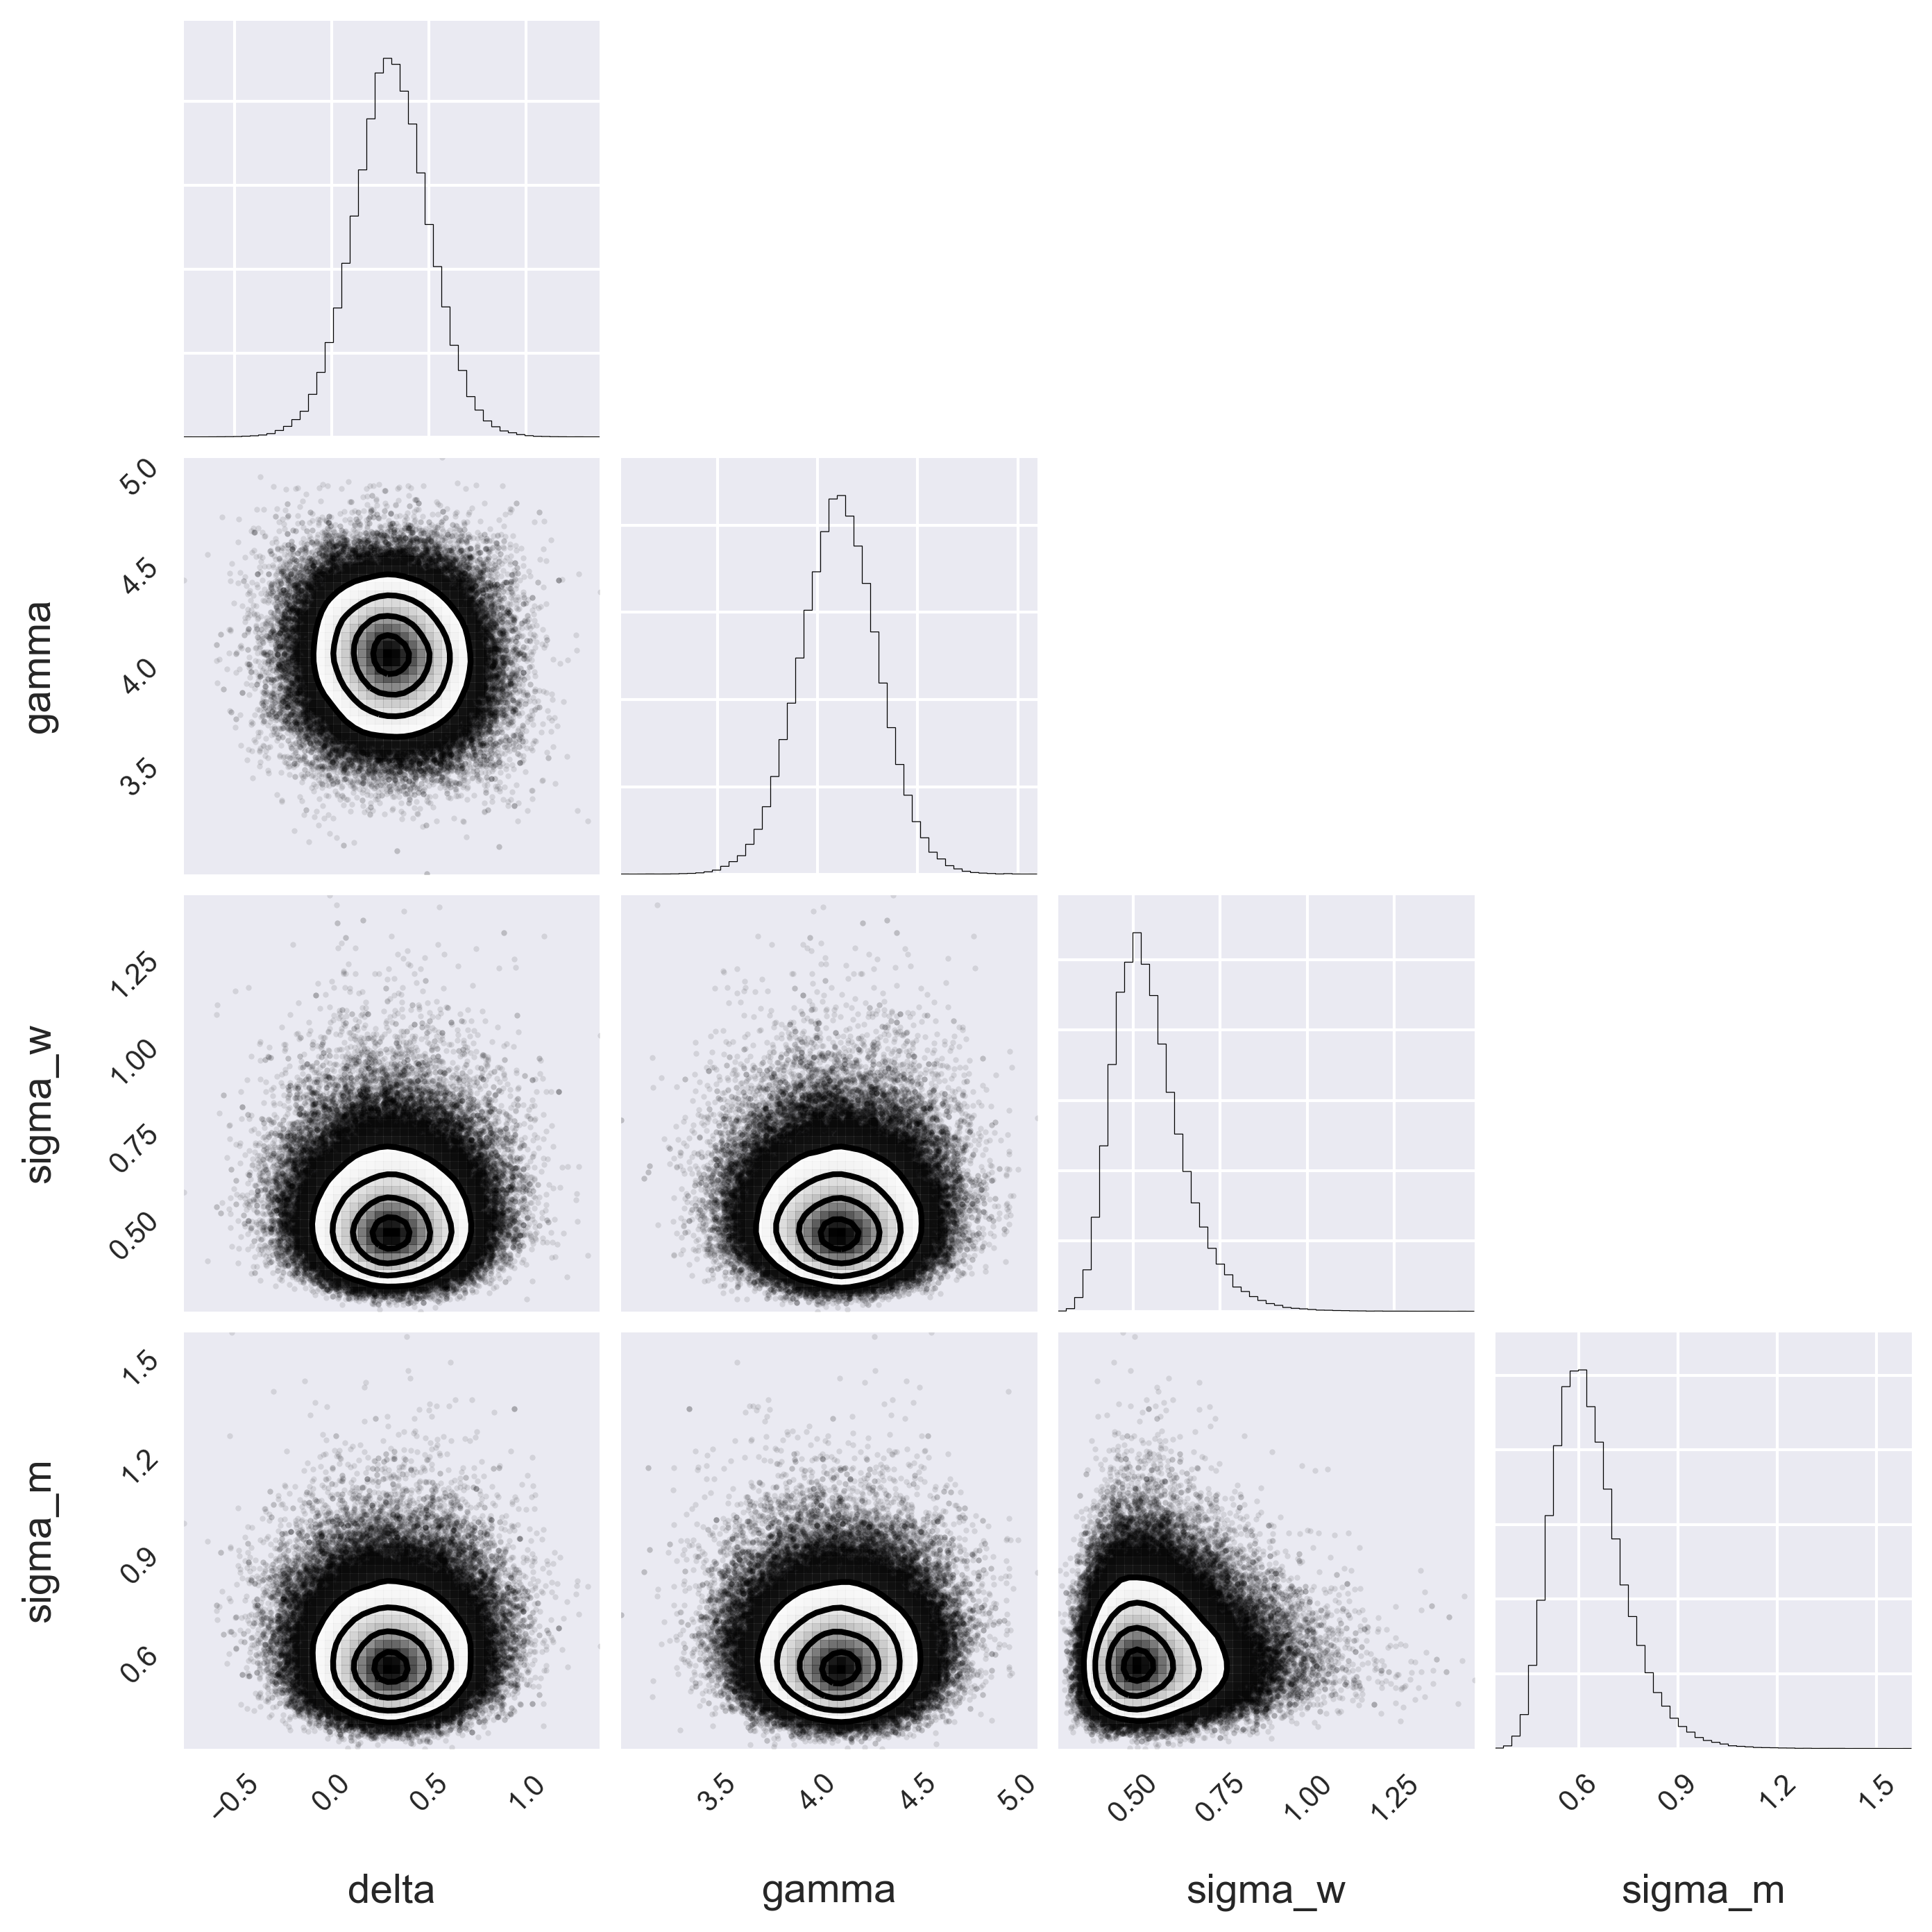

In [23]:
corner.corner(df_mcmc_1.loc[df_mcmc_1.beta_ind==0, 
                            ['delta', 'gamma', 'sigma_w', 'sigma_m']],
             bins=50, smooth=1);

There is some slight non-Gaussianity, which might add to the difference in the odds ratio. The MAP is close to what we got from optimization, so it checks out.

Importantly, the odds ratio here is in *favor* of a model $H_0'$ where the two samples have the same mean, but different variance. This is apparently contradictory to the NHST result that the p-value under the hypothesis $H_0'$ is small. But it is not contradictory. The p-value is a measure of the probability of acquired data giving a test statistic at least as extreme as the one observed if the null hypothesis is true. The odds ratio compares two models, the null hypothesis, $H_0'$, and an alternative hypothesis $H_1$ that the two samples are Gaussian distributed with unequal means and variances.

So, the (approximate) Bayesian credible region and the frequentist confidence interval almost exactly overlap, but the odds ratio and NHST give apparently different results (though, again, this is not a contradiction because they compute two different things).

### Dancing: confidence intervals and credible regions

We will now do a fun, and instructive, experiment. We will "re-acquire" the data by drawing random samples out of Gaussian distributions that have the same mean and variance as is most likely from the actual data. We will then compute the confidence interval and credible region for $\delta$ and see how they vary from experiment to experiment. We will later repeat this with p-values and odds ratios.

First, we'll write a function to generate new data.

In [24]:
def new_data(mu, sigma, n):
    """
    Generate new data
    """
    return np.maximum(np.random.normal(mu, sigma, n), 0)

Now we can do the calculations. We'll start by compute the confidence intervals for $\delta$.

In [25]:
# Number of new data sets to consider
n_new_data = 100

# Values from real data
mu_wt = np.mean(wt)
mu_mut = np.mean(mut)
sigma_wt = np.std(wt, ddof=1)
sigma_mut = np.std(mut, ddof=1)

# Number of trials to use in frequenstist calcs
n_trials = 50000

# Set up arrays for storing results
conf_int = np.empty((n_new_data, 2))
cred_reg = np.empty((n_new_data, 2))
sample_mean = np.empty(n_new_data)

# Do calcs!
for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, sigma_wt, len(wt))
    new_mut = new_data(mu_mut, sigma_mut, len(mut))
    
    # Compute confidence interval
    bs_reps = draw_bs_reps_diff_mean(new_wt, new_mut)
    conf_int[i,:] = np.percentile(bs_reps, (2.5, 97.5))
    
    # Compute Bayesian credible region
    res = analyze_bayes(new_wt, new_mut)
    err_bar = np.sqrt(res['cov_1'][0,0])
    cred_reg[i,:] = res['popt_1'][0] + 1.96 * np.array([-err_bar, err_bar])
    
# Store the results conveniently
df_conf = pd.DataFrame(columns=['conf_int_low', 'conf_int_high', 
                                'cred_reg_low', 'cred_reg_high'],
                      data=np.hstack((conf_int, cred_reg)))

# Sort by most probable delta
df_conf['delta'] = (df_conf['cred_reg_high'] + df_conf['cred_reg_low']) / 2

To visualize the results, we'll plot the frequentist and Bayesian confidence intervals and credible regions. We'll plot the confidence interval as a bar, and then the bounds of the credible region as dots.

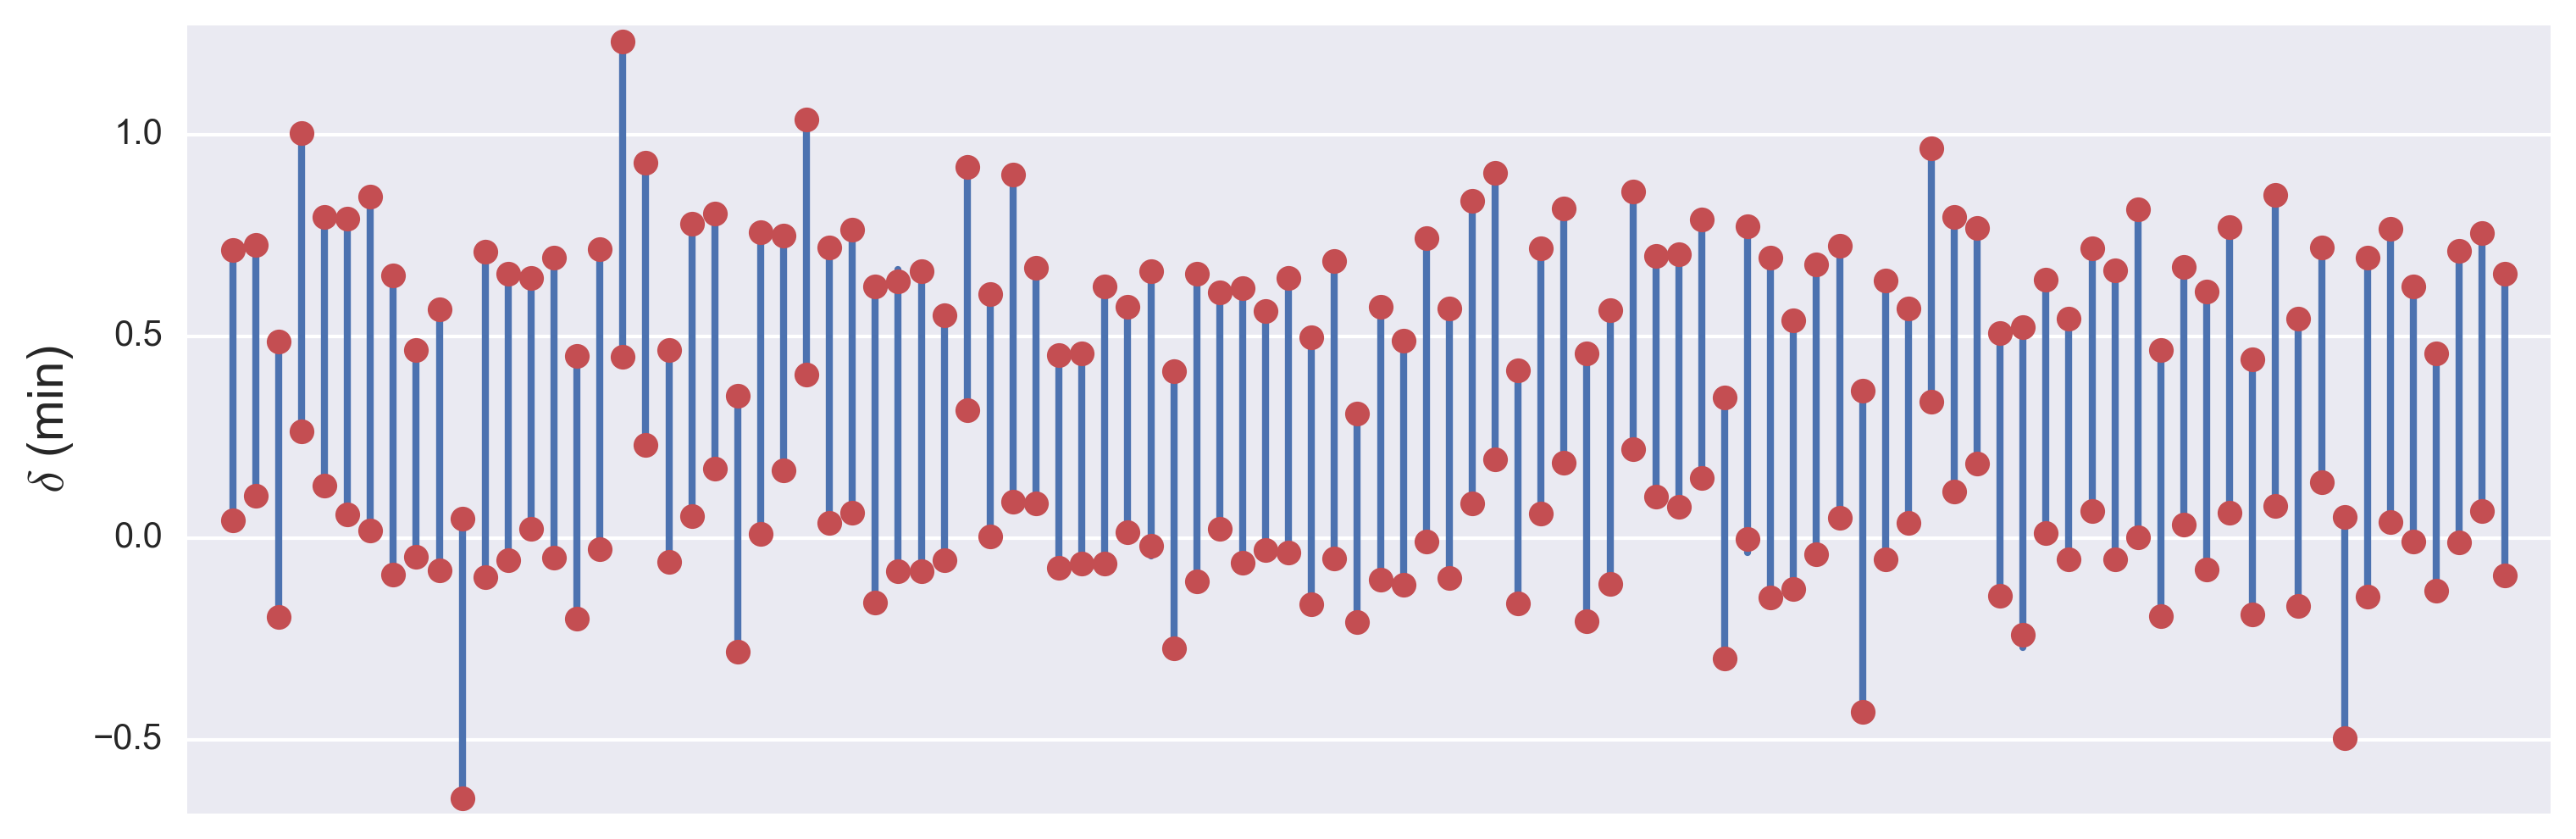

In [26]:
# Set up axis
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Make x-values for plotting to stagger
x = np.vstack(2*[np.arange(100).reshape((1, 100))])

# Plot the confidence intervals
ax.plot(x, df_conf.loc[:,['conf_int_low', 'conf_int_high']].values.transpose(), 
        '-', color=sns.color_palette()[0])

# Plot the credible region bounds
ax.plot(x, df_conf.loc[:, ['cred_reg_low', 'cred_reg_high']].values.transpose(),
        'o', color=sns.color_palette()[2]);

# Clean up
ax.set_ylabel(r'$\delta$ (min)')
ax.set_xticks([])
ax.margins(0.02)

The Bayesian credible region and frequentist confidence interval almost perfectly overlap. This is not generally the case, but is the case for these data More importantly, though, we see that the confidence interval can vary from experiment to experiment, but not that much. That is, the confidence intervals "dance" around, but all within about a factor of 3 of the original observed values.

It might be easier to visual the variability if we sort the values.

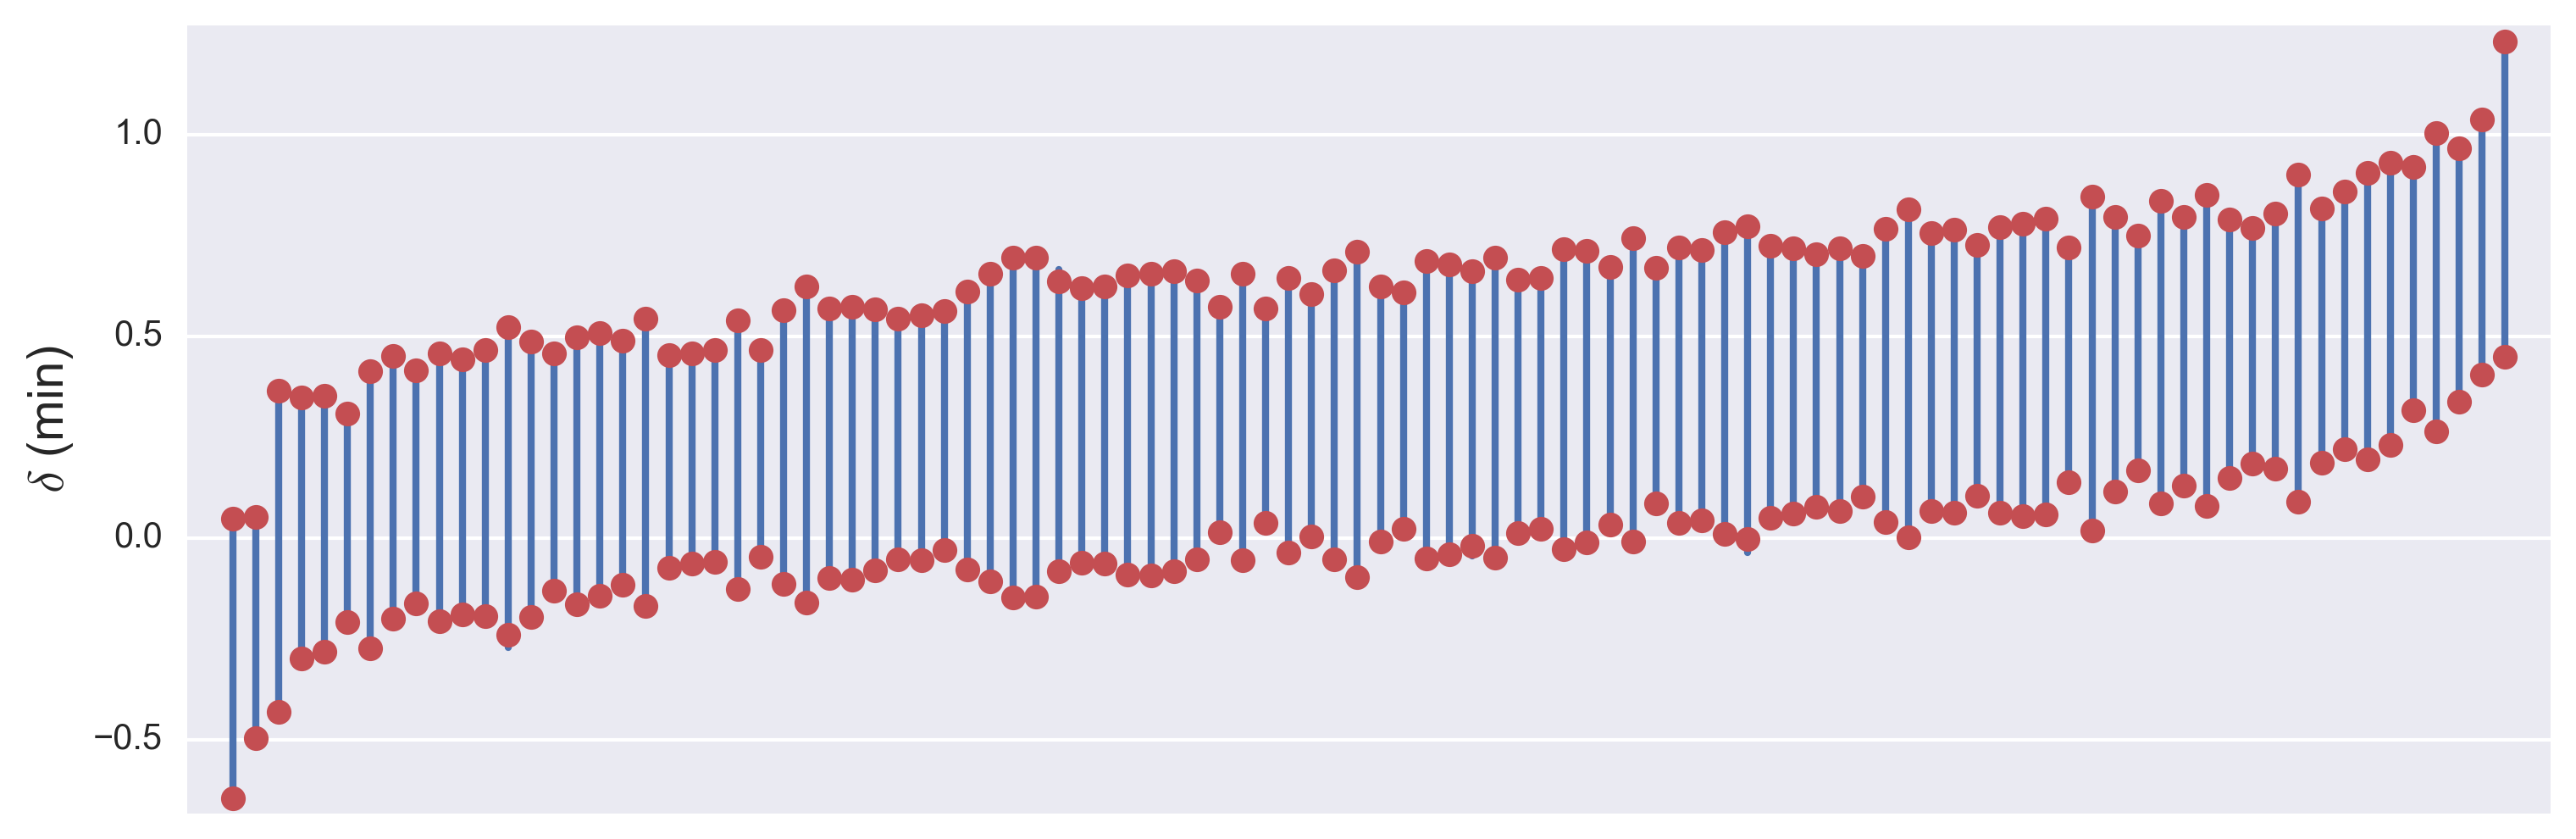

In [27]:
df_conf = df_conf.sort_values(by='delta')

# Set up axis
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Make x-values for plotting to stagger
x = np.vstack(2*[np.arange(100).reshape((1, 100))])

# Plot the confidence intervals
ax.plot(x, df_conf.loc[:,['conf_int_low', 'conf_int_high']].values.transpose(), 
        '-', color=sns.color_palette()[0])

# Plot the credible region bounds
ax.plot(x, df_conf.loc[:, ['cred_reg_low', 'cred_reg_high']].values.transpose(),
        'o', color=sns.color_palette()[2]);

# Clean up
ax.set_ylabel(r'$\delta$ (min)')
ax.set_xticks([])
ax.margins(0.02)

### Dancing: p-values and odds ratios

Now, let's look at the p-values.  We will compute two p-values, our custom bootstraped p-value with Cohen's d, and a p-value from Welch's t-test. Remember, with our custom bootstrapped p-value, the hypothesis is $H_0$, that the mutant and wild type sleep bout lengths were drawn out of distributions of the same mean (and no other assumptions). The test statistic is Cohen's d. The hypothesis in Welch's t-test, $H_0'$, is that the mutant and wild type were drawn from Gaussian distributions with the same mean, but with difference variances. The test statistic is a t-statistic, defined above. Finally, the odds ratio is the ratio of probabilities of models $H_0'$ and $H_1$, that the mutant and wild type samples were drawn from Gaussian distributions with different means and different variances.

In [28]:
# Number of new data sets to consider
n_new_data = 500

# Number of trials to use in frequenstist calcs
n_trials = 50000

# Set up arrays for storing results
cohen_p = np.empty(n_new_data)
welch_p = np.empty(n_new_data)
odds_ratio = np.empty(n_new_data)
goodfit = np.empty(n_new_data)

# Do calcs!
for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, sigma_wt, len(wt))
    new_mut = new_data(mu_mut, sigma_mut, len(mut))
    
    # Compute p-values
    cohen_p[i] = cohen_nhst(new_wt, new_mut, size=n_trials)
    welch_p[i] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1] / 2

    # Compute Bayesian odds ratio
    res = analyze_bayes(new_wt, new_mut)
    odds_ratio[i] = np.exp(res['log_odds_ratio'])
    goodfit[i] = np.exp(res['log_goodfit'])

Now, let's plot these together. For the $x$-axis, we will plot the Welch's p-value to help visualize how the custom p-value and odds ratio vary with it.

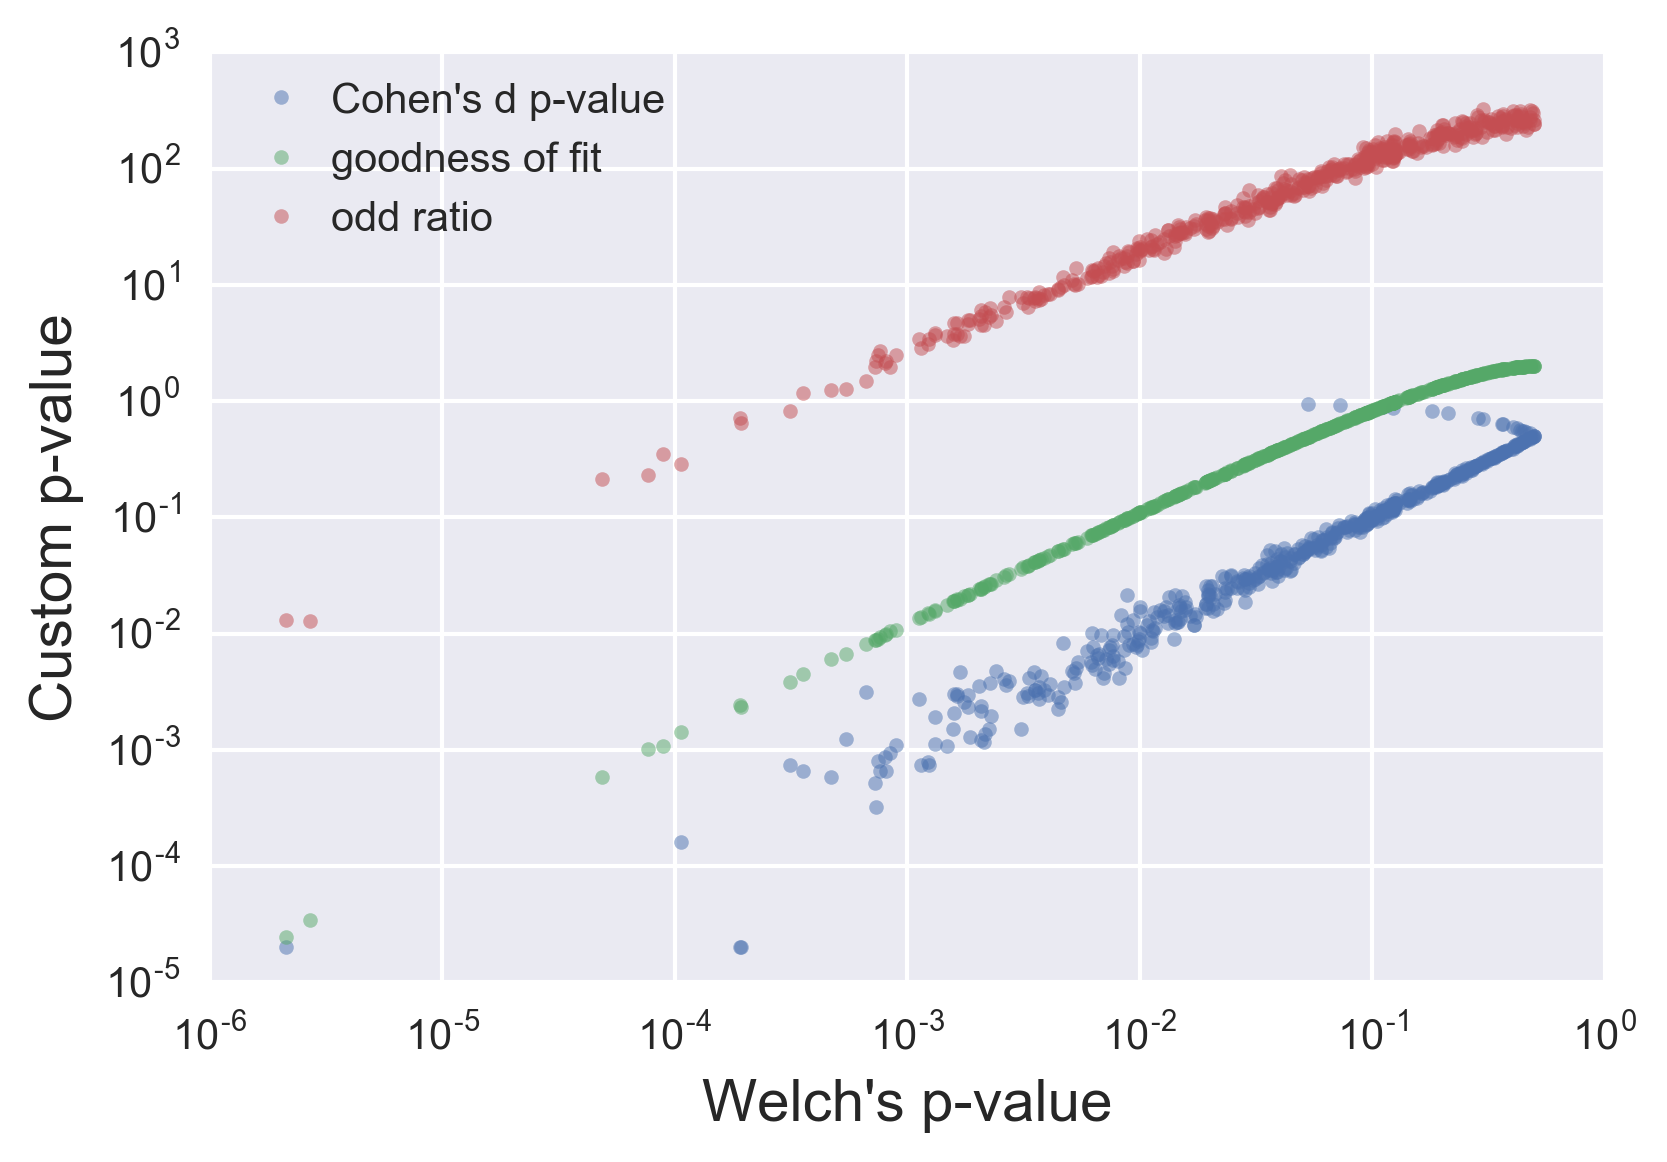

In [29]:
plt.loglog(welch_p, cohen_p, '.', alpha=0.5)
plt.loglog(welch_p, goodfit, '.', alpha=0.5)
plt.loglog(welch_p, odds_ratio, '.', color=sns.color_palette()[2], alpha=0.5)
plt.legend(("Cohen's d p-value", 'goodness of fit', 'odd ratio'), loc='upper left')
plt.xlabel('Welch\'s p-value')
plt.ylabel('Custom p-value');

The goodness of fit very closely tracks the Welch's p-value, differing by a factor of 10 over most of the values. The custom p-value computed with a Cohen's d test statistic is nearly equal to the Welch's p-value. The Bayesian odds ratio is also tracks the p-values, but is almost two orders of magnitude larger. Remember, they are computing different things, but are all in some way measures of difference between two data sets, and show similar trends.

But what is really striking here is the scale!  Wow!  In 500 repeats, we get p-values ranging over almost four orders of magnitude!  That's three exclamations in a row!  Four, now.  Those exclamation points are there to highlight that the p-value is not a reproducible statistic at all.

The Bayesian odds ratio also varies over four orders of magnitude. This is also not very reliable. The results of hypothesis tests/model selection tend to dance around a lot! Confidence intervals and credible regions don't really dance much, and p-values and odds ratios dance like [this](https://www.youtube.com/watch?v=XQ7z57qrZU8).

### The effect of sample size on dancing

The zebrafish sleep experiment had only about 20 samples, so maybe larger sample sizes will result in less extreme dancing of odds ratios and p-values. Let's do a numerical experiment to look at that. We will take 15, 20, 50, and 100 samples for our experimental "repeats" and investigate how the p-value and odds ratio varies.

In [30]:
n_new_data = 10000
n_samples = [15, 20, 50, 100]
odds = np.empty((n_new_data, len(n_samples)))
p_vals = np.empty((n_new_data, len(n_samples)))

# Do calcs!
for i in range(n_new_data):
    for j, n in enumerate(n_samples):
        # Generate new data
        new_wt = new_data(mu_wt, sigma_wt, n)
        new_mut = new_data(mu_mut, sigma_mut, n)

        # Compute odds ratio
        res = analyze_bayes(new_wt, new_mut)
        odds[i,j] = np.exp(res['log_odds_ratio'])

        # Compute p-value
        p_vals[i,j] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1]/2

We'll make a plot of the probability distribution of odds ratios.

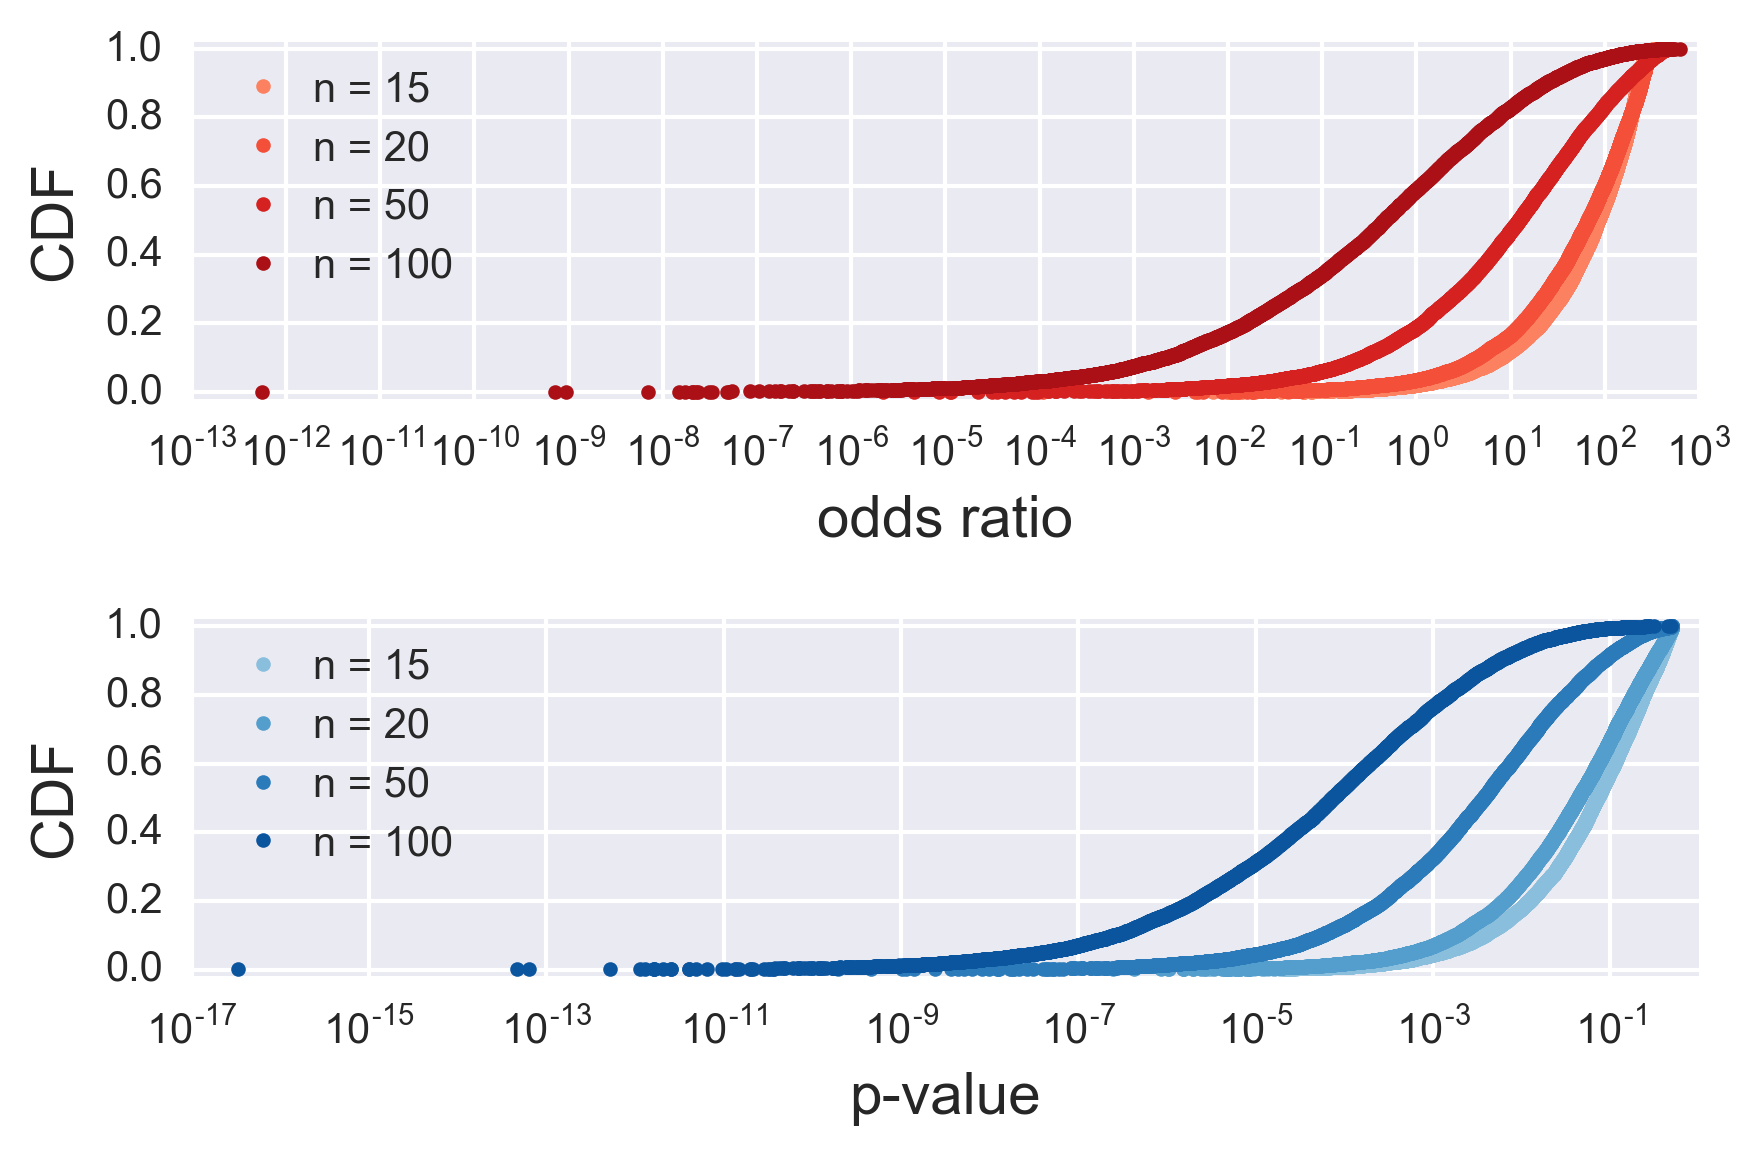

In [31]:
# Set up figure
fig, ax = plt.subplots(2, 1)

for j, n in enumerate(n_samples):
    x, y = bebi103.ecdf(odds[:,j])
    ax[0].semilogx(x, y, '.', color=sns.color_palette('Reds')[j+2],
                  label='n = {0:d}'.format(n))
    
    x, y = bebi103.ecdf(p_vals[:,j])
    ax[1].semilogx(x, y, '.', color=sns.color_palette('Blues')[j+2],
                   label='n = {0:d}'.format(n),)
    
ax[0].set_xlabel('odds ratio')
ax[0].set_ylabel('CDF')
ax[0].legend(loc='upper left')
ax[0].margins(y=0.02)

ax[1].set_xlabel('p-value')
ax[1].set_ylabel('CDF')
ax[1].legend(loc='upper left')
ax[1].margins(y=0.02)

plt.tight_layout()

We see that even though both the odds ration and the p-value have large spreads as the number of samples increases, they also shift leftward. This is because small differences in samples can be discerned with large sample sized. 

This little exercise in reproducibility tells use that because the p-values and odds ratios "dance", we had better be sure the bonfire around which they dance be far to the left.  This suggests large $n$.

I would argue that doing a "dance of the odds ratio" analysis might not be a bad idea to do if you are trying to refute or support hypotheses.  If a "repeat" of your experiment might give you an inconclusive odds ratio, you need to do more experiments.